### Load Modules

In [1]:
# path variables
import sys
project_path = '/Users/naresh/Downloads/ds_models/onboarding_fraud_model_v2/'
sys.path.insert(0, project_path+'config')
from config import SQLQuery

# core libraries
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime
import pandas as pd
import numpy as np
import textstat
import nltk
import json
import re
import validators
import requests

from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from model_evaluations import model_metrics, cross_validation
from model_building import tune_hyperparameters
from sklearn.metrics import roc_curve, precision_recall_curve, precision_score, recall_score, roc_auc_score
from matplotlib import pyplot
from collections import Counter
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from fuzzywuzzy import fuzz
from itertools import permutations


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


Custom DS Modules

In [2]:
%load_ext autoreload
%autoreload 2
from stability_monitoring import *

### Load the Dataset

In [3]:
# df = pd.read_pickle(project_path+'data/pre_split_engg_data.pkl')
year = '2022'
x_train = pd.read_pickle(project_path+'data/train_engg_data_'+year+'.pkl')
x_test = pd.read_pickle(project_path+'data/test_engg_data_'+year+'.pkl')
df = pd.concat([x_train, x_test], axis=0)

In [4]:
num_features = ['person_fraud_score', 'person_kyc_score', 'sentilink_abuse_score', 'sentilink_first_party_synthetic_score'
            ,'sentilink_third_party_synthetic_score', 'sentilink_id_theft_score', 'socure_sigma', 'socure_emailrisk', 'socure_phonerisk'
            ,'socure_addressrisk','number_of_employees']
num_features2 = ['business_address_zip', 'phone']
bool_features = ['ein_ssn','has_international_business']
cat_features = ['iovation_device_type', 'estimated_monthly_revenue', 'incoming_ach_payments', 'check_deposit_amount'
               , 'incoming_wire_transfer', 'outgoing_ach_and_checks', 'outgoing_wire_transfers', 'line_type', 'industry_category_name']
list_features = ['person_fraud_tags', 'person_kyc_tags', 'socure_reason_code', 'socure_kyc_field_validations'
                ,'socure_kyc_reason_code', 'socure_emailrisk_reason_code', 'socure_phonerisk_reason_code'
                ,'socure_addressrisk_reason_code', 'purpose_of_account', 'touch_point_emails', 'owner_list']
high_cardinality_features = ['iovation_device_timezone', 'iovation_device_ip', 'iovation_device_ip_isp', 'iovation_device_ip_org' 
                            ,'iovation_device_ip_city', 'iovation_device_ip_region', 'carrier', 'email', 'email_domain', 'industry_name'
                            , 'website', 'business_address_city', 'business_address_state', 'industry_category_from_pitch'
                            , 'company_name']
text_features = ['business_pitch']
id_features = ['application_id', 'business_id', 'train_flag', 'test_flag', 'target','expensed_fraud_loss', 'fraud_score', 'deposit_score']
datetime_features = ['application_start_datetime', 'application_complete_datetime', 'application_resubmitted_datetime']



skip_list = num_features2+['line_type','iovation_device_ip','iovation_device_ip_city','iovation_device_ip_region','email',
                           'industry_name','website','business_address_city','business_address_state','industry_category_from_pitch',
                           'company_name','person_fraud_tags','person_kyc_tags','socure_reason_code','socure_kyc_field_validations',
                           'socure_kyc_reason_code','socure_emailrisk_reason_code','socure_phonerisk_reason_code',
                           'socure_addressrisk_reason_code','purpose_of_account','touch_point_emails','owner_list','pos_counts',
                           'owner_name','text_standard','vader_neg','vader_neu','vader_pos','vader_compound','textblob_polarity',
                           'smog_index','coleman_liau_index','gunning_fog','pos_ratios']+id_features+datetime_features+text_features


#### Independent variables

In [5]:
# App features
independent_features = set(x_train.columns.to_list()) - set(skip_list)
pd.DataFrame(independent_features, columns=['feature']).to_pickle(project_path+'data/train_independent_features_'+year+'.pkl')

In [6]:
data_type_dict = x_train.dtypes.astype(str).to_dict()
data_type_mapping = {'float64':np.float64,'object':object,'bool':bool,'Int64':np.int64}
data_type_dict = {k: data_type_mapping[v] for k, v in data_type_dict.items() if v in data_type_mapping}

x_train = x_train.astype(data_type_dict)

In [7]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20265 entries, 0 to 20264
Columns: 410 entries, person_fraud_score to owner_name_email_match_flag
dtypes: datetime64[ns](3), float64(102), int64(263), object(42)
memory usage: 63.5+ MB


### Train Data

In [8]:
y_train = x_train['target']

In [9]:
# Removing reason code features as these are already encoded
x_train.drop(columns=skip_list, inplace=True)

# Encoding the categorical features
x_object_cols = x_train.select_dtypes(include=['object']).columns.to_list()
x_object_onehot = pd.get_dummies(x_train[x_object_cols]) # create dummies
x_object_onehot = x_object_onehot.astype('int')
x_train = pd.concat([x_train.drop(columns=x_object_cols), x_object_onehot], axis=1)
x_train.columns = x_train.columns.str.lower() # convert column names to lower case


In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20265 entries, 0 to 20264
Columns: 388 entries, person_fraud_score to text_standard_levels_l3
dtypes: float64(90), int64(298)
memory usage: 60.1 MB


In [11]:
# Save the train data features to use later in the test and oot data preparation
x_train = x_train[x_train.columns]
pd.DataFrame(x_train.columns.to_list(), columns=['feature']).to_pickle(project_path+'models/train_data_columns_'+year+'.pkl')
x_train.shape

(20265, 388)

### Test data

In [12]:
y_test = x_test['target']
independent_features = pd.read_pickle(project_path+'data/train_independent_features_'+year+'.pkl')['feature'].to_list()
x_test = x_test[independent_features]

In [13]:
data_type_dict = x_test.dtypes.astype(str).to_dict()
data_type_mapping = {'float64':np.float64,'object':object,'bool':bool,'Int64':np.int64}
data_type_dict = {k: data_type_mapping[v] for k, v in data_type_dict.items() if v in data_type_mapping}

x_test = x_test.astype(data_type_dict)

In [14]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8686 entries, 0 to 8685
Columns: 362 entries, socure_kyc_reason_code_r934 to flesch_reading_ease
dtypes: float64(90), int64(263), object(9)
memory usage: 24.0+ MB


#### Feature creation

In [15]:
x_test.shape, y_test.shape

((8686, 362), (8686,))

In [16]:
# Removing reason code features as these are already encoded
# x_test.drop(columns=skip_list, inplace=True)

# Encoding the categorical features
x_object_cols = x_test.select_dtypes(include=['object']).columns.to_list()
x_object_onehot = pd.get_dummies(x_test[x_object_cols]) # create dummies
x_object_onehot = x_object_onehot.astype('int')
x_test = pd.concat([x_test.drop(columns=x_object_cols), x_object_onehot], axis=1)
x_test.columns = x_test.columns.str.lower() # convert column names to lower case


In [17]:
# Filter only the final independent features used in the training data
train_cols = pd.read_pickle(project_path+'models/train_data_columns_'+year+'.pkl')['feature'].to_list()
df_tmp = pd.DataFrame(index=range(x_test.shape[0]),columns=train_cols)
df_tmp = df_tmp.fillna(0) # creating a dummy df using the columns from train dataset
df_tmp.update(x_test) # update the dummy df with test df values
x_test = df_tmp.copy()
x_test.shape

(8686, 388)

### OOT Data

In [18]:
# oot_df = pd.read_pickle(project_path+'data/nsl_oot_dataset_2023-05-30.pkl')
# y_oot = oot_df['ns_flag']

# # Adding segment test data
# segment_oot = pd.read_pickle(project_path+'data/segment_processed_data_oot.pkl')
# oot_df = pd.merge(oot_df, segment_oot, on='application_id', how='inner')
# x_oot = oot_df[raw_features]

In [19]:
# for col in string_features:
#     x_oot[col] = x_oot[col].str.lower()

In [20]:
# x_oot.shape, y_oot.shape

In [21]:
# x_oot = convert_nulls_to_one_format(df=x_oot)
# x_oot = fill_null_values(df_impute_apps, x_oot)
# x_oot = fill_null_values(df_impute, x_oot)

# x_oot = feature_engineering_app(df=x_oot)
# x_oot = feature_engineering_alloy(df=x_oot, training=False)

# # Removing reason code features as these are already encoded
# x_oot.drop(columns=ida_reason_cols+socure_reason_cols, inplace=True)

# # Encoding the categorical feataures
# x_object_cols = x_oot[independent_features_alloy_tmp].select_dtypes(include=['object']).columns.to_list()
# x_object_cols = x_object_cols+['industry_category_name']

# x_object_onehot = pd.get_dummies(x_oot[x_object_cols]) # create dummies
# x_object_onehot = x_object_onehot.astype('int')
# x_oot = pd.concat([x_oot.drop(columns=x_object_cols), x_object_onehot], axis=1)
# x_oot.columns= x_oot.columns.str.lower() # convert column names to lower case

In [22]:
# # Filter only the final independent features used in the training data
# train_cols = pd.read_pickle(project_path+'models/train_data_columns.pkl')['feature'].to_list()
# df_tmp = pd.DataFrame(index=range(x_oot.shape[0]),columns=train_cols)
# df_tmp = df_tmp.fillna(0)
# df_tmp.update(x_oot)
# x_oot = df_tmp.copy()
# x_oot.shape

### Model Training

In [23]:
# Class imbalance
y_train[y_train==0].shape[0]/y_train.sum(), y_test[y_test==0].shape[0]/y_test.sum()

(25.594488188976378, 25.56269113149847)

#### Initial Model Fit to find the best features: Intuition and reasonable values
First approach is to start with reasonable parameters instead of the default xgboost model

In [24]:
tuned_model = XGBClassifier(max_depth=3, colsample_bytree=1 ,subsample=1 ,scale_pos_weight=20 ,learning_rate=0.1 
                            ,random_state=3)
tuned_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=3, ...)

TRAIN RESULTS:

Accuracy Score: 0.81 

Confusion Matrix:
        pred:1  pred:0
true:1     633     129
true:0    3653   15850 

False Positive Rate: 0.19
True Positive Rate: 0.83
AUC: 0.82 

Sensitivity: 0.83
Specificity: 0.81 

F1 Score: 0.25 

KS Score:
KstestResult(statistic=0.17389587959536146, pvalue=2.0504379930095164e-268, statistic_location=0.0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     19503
         1.0       0.15      0.83      0.25       762

    accuracy                           0.81     20265
   macro avg       0.57      0.82      0.57     20265
weighted avg       0.96      0.81      0.87     20265

Gain Chart


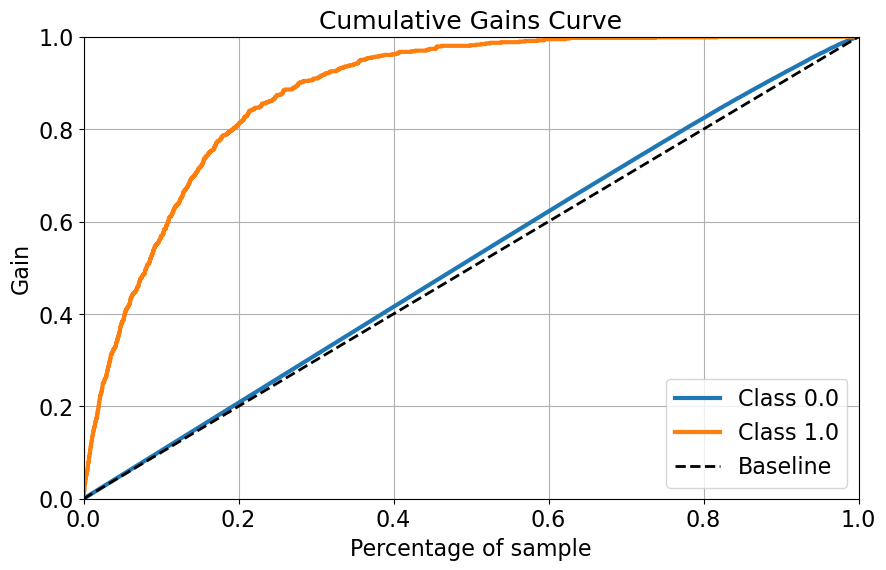

Lift Chart


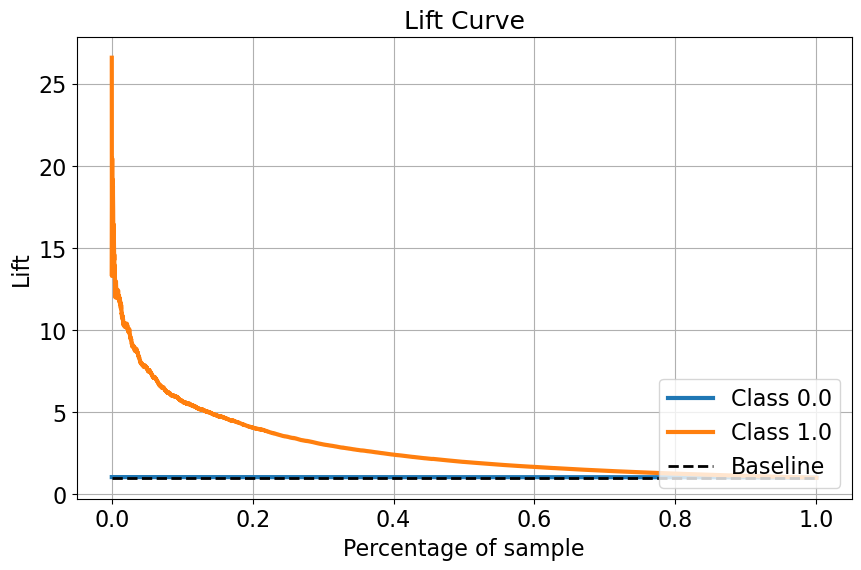



TEST RESULTS:

Accuracy Score: 0.8 

Confusion Matrix:
        pred:1  pred:0
true:1     175     152
true:0    1616    6743 

False Positive Rate: 0.19
True Positive Rate: 0.54
AUC: 0.67 

Sensitivity: 0.54
Specificity: 0.81 

F1 Score: 0.17 

KS Score:
KstestResult(statistic=0.1685470872668662, pvalue=4.271783517249769e-108, statistic_location=0.0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.88      8359
         1.0       0.10      0.54      0.17       327

    accuracy                           0.80      8686
   macro avg       0.54      0.67      0.52      8686
weighted avg       0.94      0.80      0.86      8686

Gain Chart


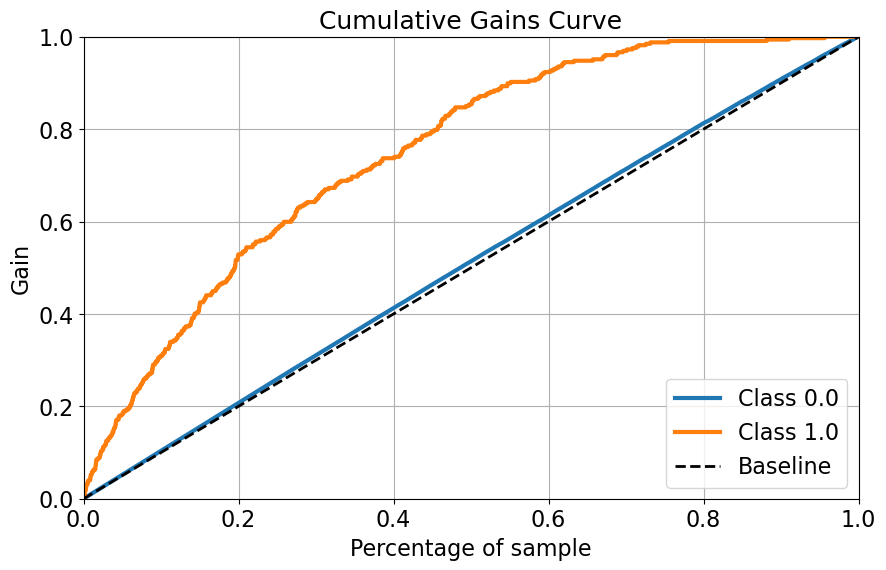

Lift Chart


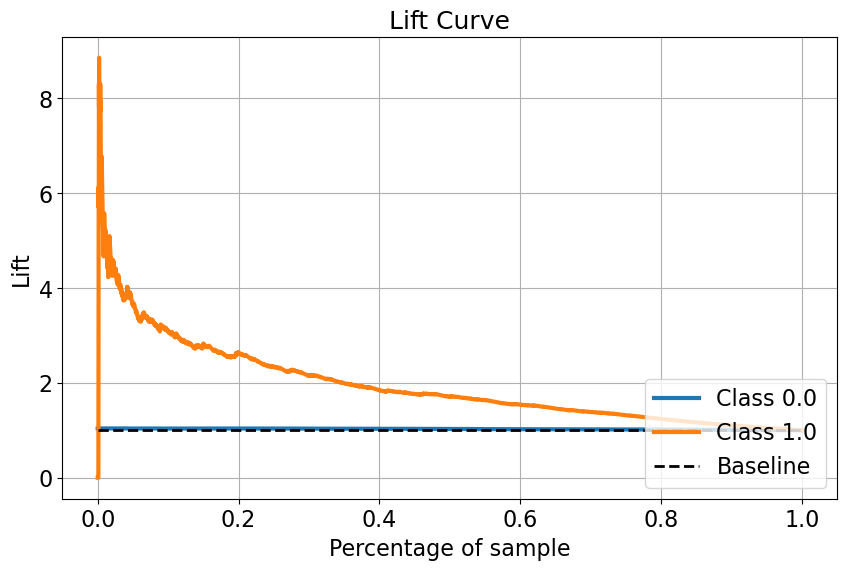

In [25]:
# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model.predict(x_train)
predicted_probas = tuned_model.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model.predict(x_test)
predicted_probas = tuned_model.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

# print("\n\nOOT RESULTS:\n")
# y_pred = tuned_model.predict(x_oot)
# predicted_probas = tuned_model.predict_proba(x_oot)
# model_metrics(y_pred, y_oot, predicted_probas)

In [26]:
x_train['proba'] = tuned_model.predict_proba(x_train[train_cols])[:,1:].flatten()
x_test['proba'] = tuned_model.predict_proba(x_test[train_cols])[:,1:].flatten()

cols_to_add = ['fraud_score', 'target', 'expensed_fraud_loss']
x_train[cols_to_add] = df[df.train_flag==1][cols_to_add]
x_test[cols_to_add] = df[df.test_flag==1][cols_to_add]


In [27]:
tmp_train = x_train[x_train.target==1][['proba','fraud_score','target','expensed_fraud_loss']]
tmp_test = x_test[x_test.target==1][['proba','fraud_score','target','expensed_fraud_loss']]

In [28]:
tmp_train[tmp_train.proba>0.5].expensed_fraud_loss.sum()/tmp_train.expensed_fraud_loss.sum(), tmp_test[tmp_test.proba>0.5].expensed_fraud_loss.sum()/tmp_test.expensed_fraud_loss.sum()


(0.8617298990661149, 0.5007040349265527)

In [29]:
tmp_train[tmp_train.proba>0.5].target.sum()/tmp_train.target.sum(), tmp_test[tmp_test.proba>0.5].target.sum()/tmp_test.target.sum()

(0.8307086614173228, 0.5351681957186545)

In [30]:
tmp_train[(tmp_train.proba>0.5) & (tmp_train.expensed_fraud_loss==0)].target.sum(), tmp_train[(tmp_train.proba>0.5) & (tmp_train.expensed_fraud_loss==0)].target.sum()/tmp_train[(tmp_train.expensed_fraud_loss==0)].target.sum()


(74.0, 0.7326732673267327)

In [31]:
tmp_test[(tmp_test.proba>0.5) & (tmp_test.expensed_fraud_loss==0)].target.sum(), tmp_test[(tmp_test.proba>0.5) & (tmp_test.expensed_fraud_loss==0)].target.sum()/tmp_test[(tmp_test.expensed_fraud_loss==0)].target.sum()


(26.0, 0.5777777777777777)

In [32]:
df[df.train_flag==1].expensed_fraud_loss.sum(), df[df.test_flag==1].expensed_fraud_loss.sum()

(737537.25, 309018.76)

#### Feature Importance

In [33]:
feature_imp_df = pd.DataFrame(zip(x_train.columns.to_list(), tuned_model.feature_importances_), columns=['feature','importance'])
feature_imp_df = feature_imp_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
feature_imp_df[feature_imp_df.importance>=0.005]

,feature,importance
0,total_txns_vol,0.033686
1,socure_emailrisk_reason_code_r566,0.030801
2,socure_phonerisk,0.022527
3,total_outgoing_vol,0.022329
4,iovation_device_type_android,0.016578
...,...,...
82,sentilink_id_theft_score,0.005071
83,socure_emailrisk_reason_code_r569,0.005069
84,linsear_write_formula,0.005068
85,wire_outgoing_to_incoming_ratio,0.005058


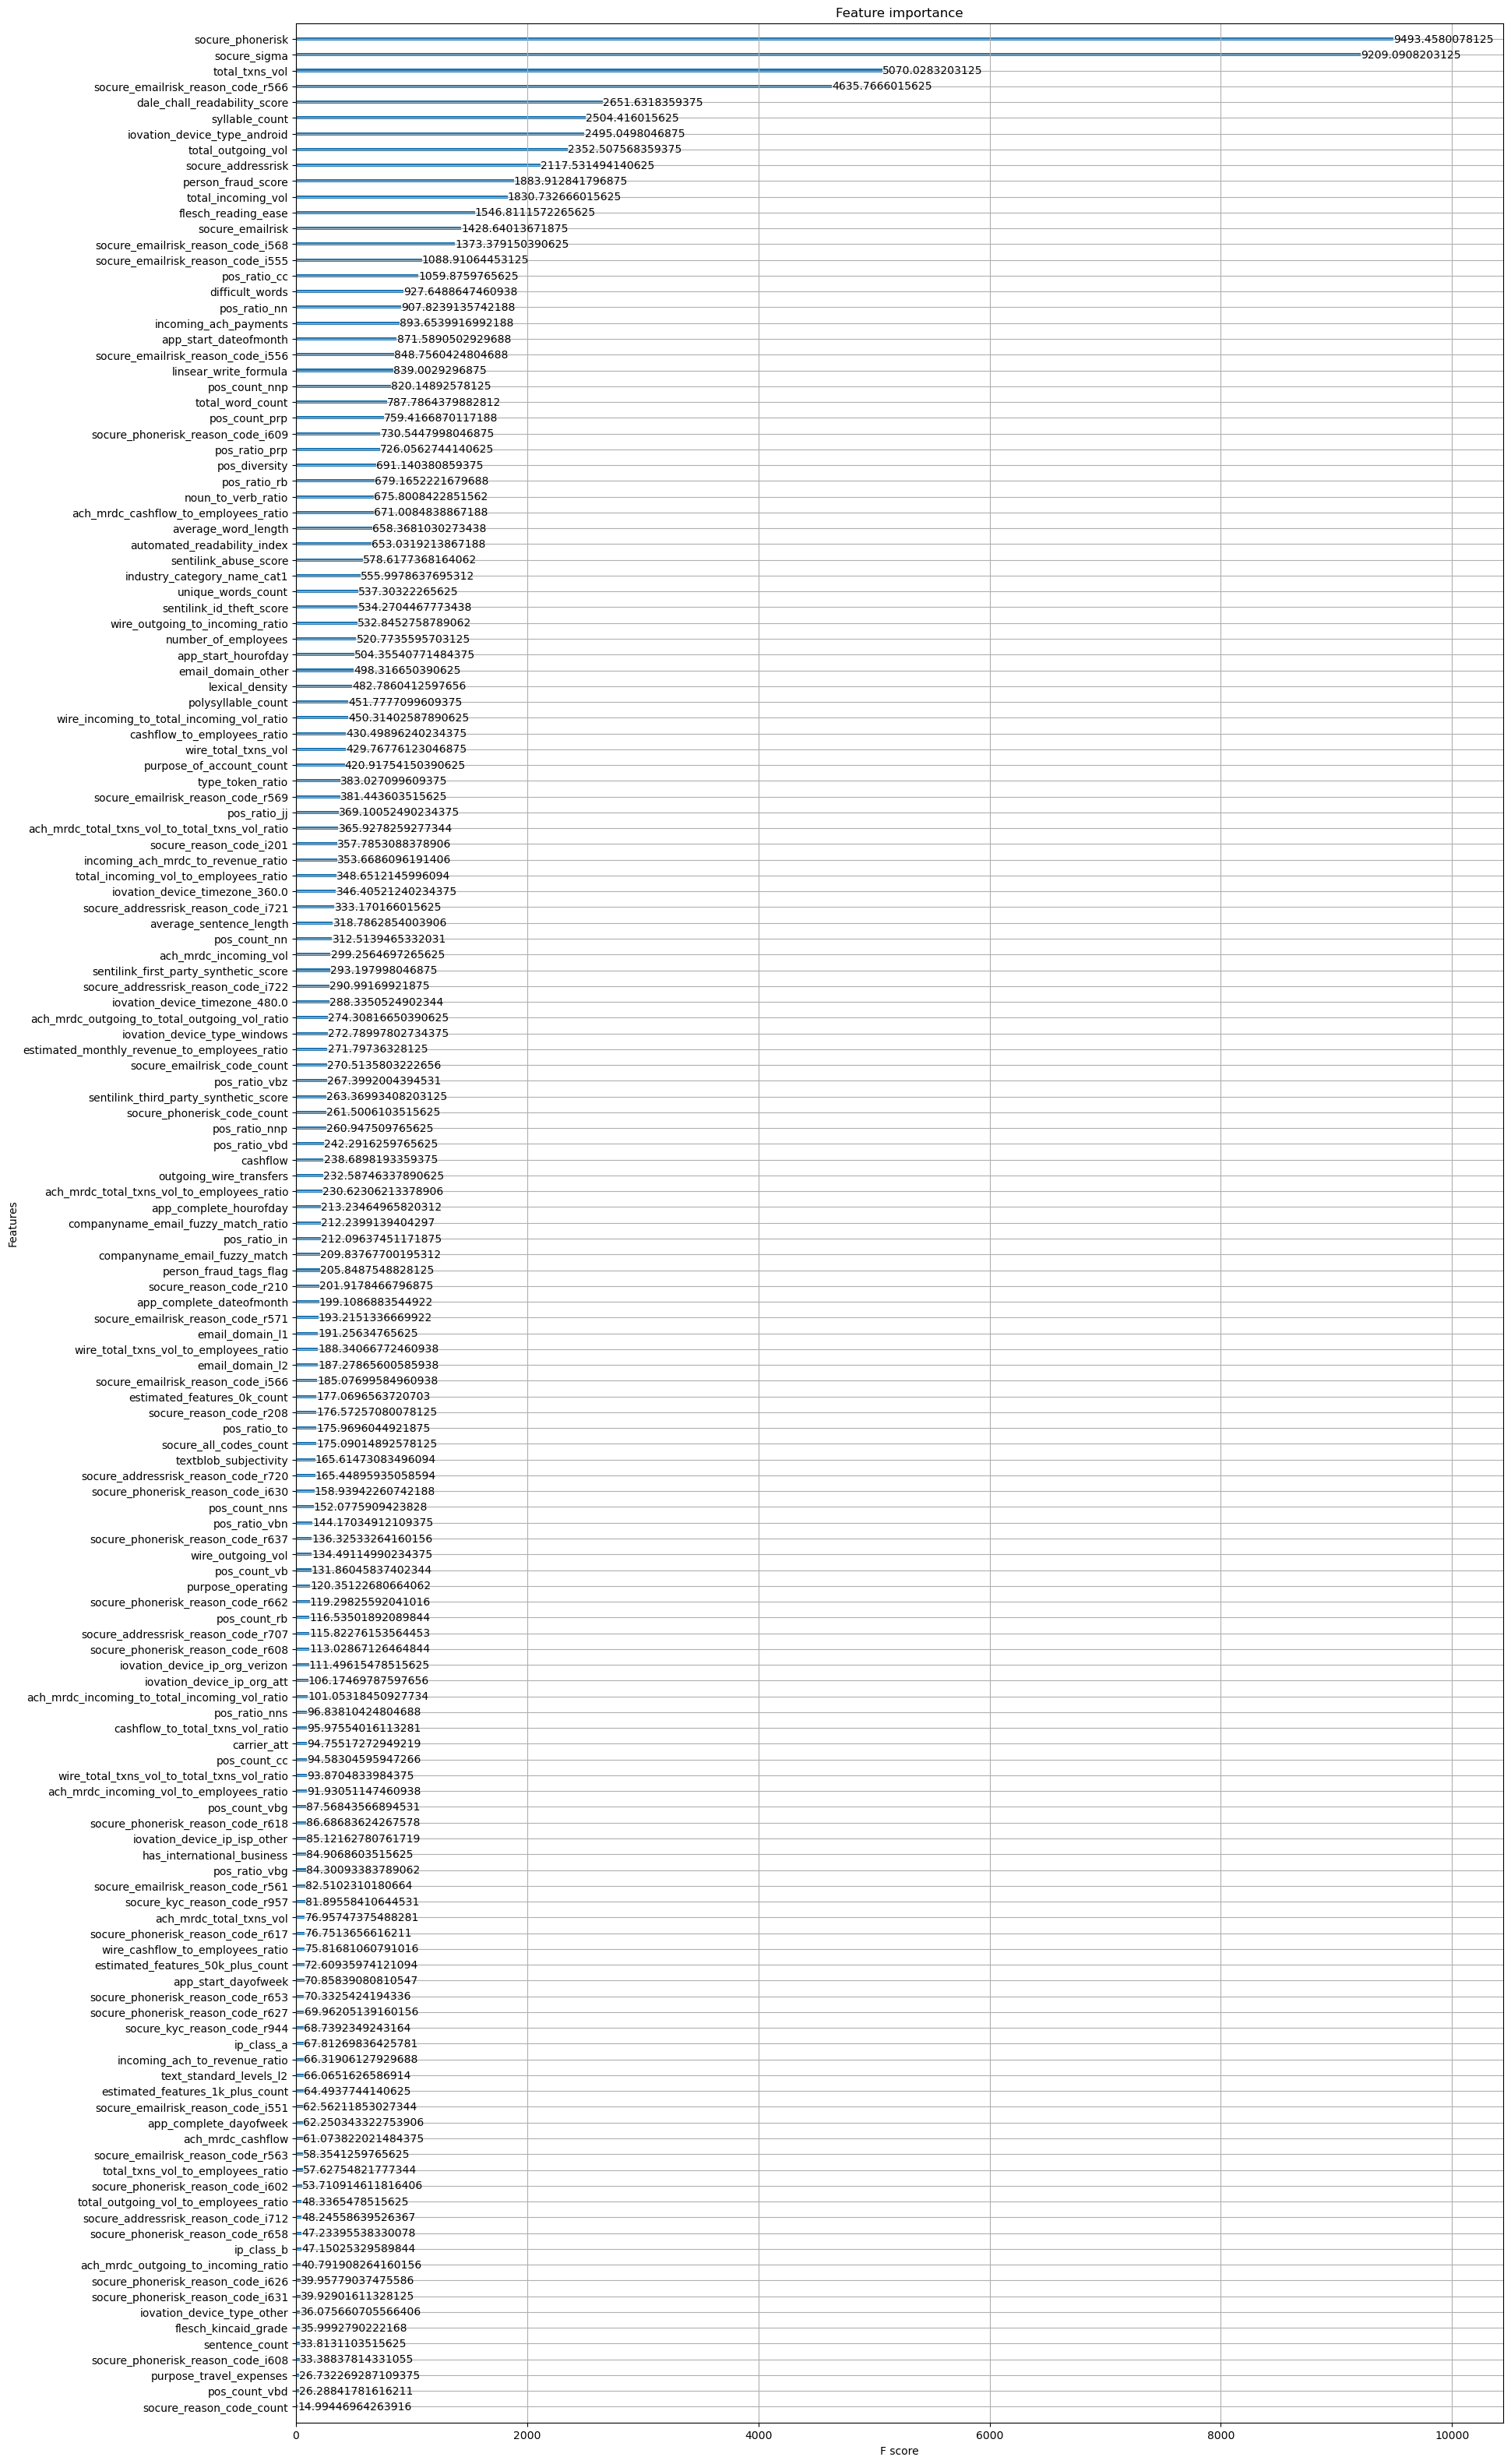

In [34]:
plt.rcParams["figure.figsize"] = (20,40)
plot_importance(tuned_model, importance_type='total_gain')
plt.show()

#### Train rank ordering

In [35]:
# train
x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

df_train = x_train.copy()
df_train['target'] = y_train
df_train['proba'] = tuned_model.predict_proba(x_train.drop(columns=cols_to_add+['proba']))[:,1:].flatten()

# custom_bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
custom_bins = [0.0, 0.2, 0.4, 0.6, 1.0]
df_train['proba'] = np.round(df_train['proba'], 3)
df_train['DecileRank']= pd.cut(df_train['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_train.groupby(by='DecileRank')['target'].mean())
df_stats['volume'] = df_train.groupby(by='DecileRank')['target'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats['loss'] = df_train.groupby(by='DecileRank')['expensed_fraud_loss'].sum()
df_stats['loss%'] = np.round((df_stats['loss'] / df_stats['loss'].sum())*100, 2)

df_stats

,target,volume,volume%,loss,loss%
DecileRank,,,,,
"(0.0, 0.2]",0.000393,7635,37.68,2209.27,0.30
"(0.2, 0.4]",0.008103,5800,28.62,34907.03,4.73
"(0.4, 0.6]",0.056045,4657,22.98,272671.79,36.97
"(0.6, 1.0]",0.207547,2173,10.72,427749.16,58.00


#### Test rank ordering

In [36]:
# test
x_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

df_test = x_test.copy()
df_test['target'] = y_test
df_test['proba'] = tuned_model.predict_proba(x_test.drop(columns=cols_to_add+['proba']))[:,1:].flatten()

df_test['proba'] = np.round(df_test['proba'], 3)
df_test['DecileRank']= pd.cut(df_test['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_test.groupby(by='DecileRank')['target'].mean())
df_stats['volume'] = df_test.groupby(by='DecileRank')['target'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats['loss'] = df_test.groupby(by='DecileRank')['expensed_fraud_loss'].sum()
df_stats['loss%'] = np.round((df_stats['loss'] / df_stats['loss'].sum())*100, 2)

df_stats

,target,volume,volume%,loss,loss%
DecileRank,,,,,
"(0.0, 0.2]",0.005578,3227,37.15,19057.44,6.17
"(0.2, 0.4]",0.033202,2530,29.13,95532.96,30.91
"(0.4, 0.6]",0.060649,2094,24.11,112444.13,36.39
"(0.6, 1.0]",0.117365,835,9.61,81984.23,26.53


### Combined Rank Ordering

In [37]:
# 
df_all = pd.concat([x_train, x_test], axis=0)
df_all.reset_index(drop=True, inplace=True)
df_all['proba'] = tuned_model.predict_proba(df_all.drop(columns=cols_to_add+['proba']))[:,1:].flatten()

df_all['proba'] = np.round(df_all['proba'], 3)
df_all['DecileRank']= pd.cut(df_all['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_all.groupby(by='DecileRank')['target'].mean())
df_stats['volume'] = df_all.groupby(by='DecileRank')['target'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats['loss'] = df_all.groupby(by='DecileRank')['expensed_fraud_loss'].sum()
df_stats['loss%'] = np.round((df_stats['loss'] / df_stats['loss'].sum())*100, 2)

df_stats

,target,volume,volume%,loss,loss%
DecileRank,,,,,
"(0.0, 0.2]",0.001933,10862,37.52,21266.71,2.03
"(0.2, 0.4]",0.015726,8330,28.77,130439.99,12.46
"(0.4, 0.6]",0.057473,6751,23.32,385115.92,36.80
"(0.6, 1.0]",0.182513,3008,10.39,509733.39,48.71


In [38]:
# pd.options.display.max_rows=1000
# pd.DataFrame(df_all.proba.value_counts()).reset_index().sort_values(by=['index'], ascending=False)

In [39]:
datetime.datetime.now()

datetime.datetime(2024, 6, 9, 18, 57, 51, 555871)

#### OOT rank ordering

In [42]:
# x_oot.reset_index(drop=True,inplace=True)
# y_oot.reset_index(drop=True,inplace=True)

# df_oot = x_oot.copy()
# df_oot['ns_flag'] = y_oot
# df_oot['proba'] = tuned_model.predict_proba(x_oot)[:,1:].flatten()

# df_oot['proba'] = np.round(df_oot['proba'], 3)
# df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
# df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
# df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
# df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
# df_stats

#### Hyperparameter tuning

In [ ]:
estimator = XGBClassifier(random_state=3)

parameters = {
    'max_depth': range (2, 5, 1),
    'learning_rate': [0.05, 0.1, 0.15],
    'scale_pos_weight' : range(10, 25, 5)
}

x_train_test = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)
y_train_test = np.concatenate([y_train, y_test], axis=0)

best_model = tune_hyperparameters(x_train_test, y_train_test, estimator, parameters, metric='roc_auc', cv_folds=3)


/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/pyt

/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/pyt

/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/pyt

[18:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:56:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

In [ ]:
best_model

In [ ]:
# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = best_model.predict(x_train)
predicted_probas = best_model.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model.predict(x_test)
predicted_probas = best_model.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model.predict(x_oot)
predicted_probas = best_model.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Prediction on the train, test & oot datasets
best_model2 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=15, learning_rate=0.1)
best_model2.fit(x_train, y_train)

print("TRAIN RESULTS:\n")
y_pred = best_model2.predict(x_train)
predicted_probas = best_model2.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model2.predict(x_test)
predicted_probas = best_model2.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model2.predict(x_oot)
predicted_probas = best_model2.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Prediction on the train, test & oot datasets
best_model2 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=7, learning_rate=0.1)
best_model2.fit(x_train, y_train)

print("TRAIN RESULTS:\n")
y_pred = best_model2.predict(x_train)
predicted_probas = best_model2.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model2.predict(x_test)
predicted_probas = best_model2.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model2.predict(x_oot)
predicted_probas = best_model2.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Prediction on the train, test & oot datasets
best_model2 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=7, learning_rate=0.1)
best_model2.fit(x_train, y_train)

print("TRAIN RESULTS:\n")
y_pred = best_model2.predict(x_train)
predicted_probas = best_model2.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model2.predict(x_test)
predicted_probas = best_model2.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model2.predict(x_oot)
predicted_probas = best_model2.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

#### Selecting the top features basis the model with depth:3 and weight:7, which is producing the better metrics: Precision, Recall & AUC.


In [ ]:
feature_imp_df = pd.DataFrame(zip(x_train.columns.to_list(), best_model2.feature_importances_), columns=['feature','importance'])
feature_imp_df = feature_imp_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
feature_imp_df[feature_imp_df.importance>=0.005]


In [ ]:
top_features_41 = feature_imp_df[:41]['feature'].to_list()

In [ ]:
# Using the top 41 features, training the model
top_features_41 = feature_imp_df[:41]['feature'].to_list()
x_tr = x_train[top_features_41]
x_te = x_test[top_features_41]
x_oo = x_oot[top_features_41]


tuned_model7 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=7, learning_rate=0.1)
tuned_model7.fit(x_tr, y_train)

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model7.predict(x_tr)
predicted_probas = tuned_model7.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model7.predict(x_te)
predicted_probas = tuned_model7.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model7.predict(x_oo)
predicted_probas = tuned_model7.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

### Selecting the optimal number of features

In [ ]:
# Feature Importance Custom Function
def feature_importance(model, X, imp_type='gain'):
    '''
    Returns the best binary classifier with tuned hyperparameter set

        Parameters:
                model (object): model object of the binary classifier
                X (dataframe(pandas)): pandas dataframe of predictor variables in train dataset
                imp_type (str): importance type to be plotted from the model, choose from ['gain', 'cover', 'weight', 'total_gain', 'total_cover']
        
        Prints:
                feat_importances (plot): plots the feature importance

        Returns:
                feat_importance (dataframe(pandas)): pandas dataframe of feature importances

        Raises:
                ValueError: If X is not pandas dataframe
    '''
    # Check if train dataset is passed as dataframe
    if type(X) != pd.core.frame.DataFrame:
        raise ValueError('Train dataset not passed as pandas dataframe')
    
    # Check if the classifier is tree based
    if type(model).__name__ in (['DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier']):
        importance_array = model.feature_importances_
    else:
        importance_array = model.coef_[0]
    
    # Extract the feature importance
    feat_importances = pd.DataFrame(importance_array, index=X.columns, columns=['importance'])

    # Plot the feature importance
    # fig = px.bar(feat_importances, orientation='h')
    # fig.update_layout(yaxis={'categoryorder':'total ascending'})
    # fig.show()

    # Return the feature importance dataframe
    return feat_importances
imp = feature_importance(tuned_model7, x_train[top_features_41], imp_type='total_gain')


In [ ]:
imp_idx = imp.sort_values(by='importance', ascending=False).index[:41]
imp = imp.loc[imp_idx]

In [ ]:
imp.reset_index()

In [ ]:
imp.shape

Find the optimal number of features

In [ ]:
# functions to build models with different feature counts by iteratively removing least important features
def get_feature_importance(X_train, X_test):
    xgb_model = XGBClassifier(max_depth=3, scale_pos_weight=7 ,learning_rate=0.1 ,random_state=3
                              ,eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    imp = feature_importance(xgb_model, X_train, imp_type='total_gain')
    return imp,xgb_model

def imp_iter(X_train,X_test,imp_data,threshold):
    X_train_temp = X_train.copy()
    X_test_temp = X_test.copy()
    while X_train_temp.shape[1] > threshold:
        features = list(X_train_temp.columns)
        feature_exc = imp_data.sort_values(by='importance', ascending=True).index[0]
        features.remove(feature_exc)
        X_train_temp = X_train_temp[features]
        X_test_temp = X_test_temp[features]
        imp_data, xgb_model2 = get_feature_importance(X_train_temp, X_test_temp)
    print(imp_data.shape[0])
    pd.DataFrame(imp_data.index.to_list(), columns=['column']).to_pickle(project_path+'models_tmp2/top_features_'+str(threshold)+'.pkl')
    pickle.dump(xgb_model2, open(f'{project_path}models_tmp2/xgb_{threshold}.pkl', 'wb'))
    return

def var_imp_iter(X_train,X_test,imp_data,var_arr):
    for threshold in var_arr:
        imp_iter(X_train, X_test, imp_data, threshold)
    return

In [ ]:
x_train2 = x_train[top_features_41]
x_test2 = x_test[top_features_41]

In [ ]:
# iteratively removing features one by one and saving models with the provided feature counts list.
arr = [10,15,20,25,30,35,40]
var_imp_iter(x_train2,x_test2,imp,arr)

In [ ]:
# Loading models and comparing their AUC performance
features_count_arr = [40,35,30,25,20,15,10]
model_arr = []
for threshold in features_count_arr:
    model_arr.append(pickle.load(open(f'{project_path}models_tmp2/xgb_{threshold}.pkl', "rb")))
model_arr

Running each model with iterations over 50 seeds, to check the performance metrics and finalise the number of features for the model.

In [ ]:
%load_ext autoreload
%autoreload 2

from modules.validation import validator
val = validator()

In [ ]:
def run_pipe_test(df,  dependent_variable, model, threshold):
    
    print('\n\nNumber of features: ',threshold)
    # Set seed for train test split 
#     selected_features = model.feature_names_in_
    selected_features = pd.read_pickle(project_path+'models_tmp2/top_features_'+str(threshold)+'.pkl')['column'].to_list()
    traindict0, testdict0   = val.rank_order_test(df, selected_features, dependent_variable, model, 0)
    
    results_df = pd.DataFrame(columns=['seed', 
                               'accuracy_train','accuracy_test',
                               'auc_train','auc_test', 
                               'precision_train','precision_test', 
                               'recall_train','recall_test',
                              'fpr_train','fpr_test',
                              'tpr_train','tpr_test',
                              'sensitivity_train','sensitivity_test',
                              'specificity_train','specificity_test'])
    dict0 = {'seed':0, 
             'accuracy_train': traindict0['accuracy_score'], 'accuracy_test':testdict0['accuracy_score'],
             'auc_train' : traindict0['AUC'], 'auc_test' : testdict0['AUC'],
             'precision_train':traindict0['precision'],'precision_test':testdict0['precision'],
             'recall_train':traindict0['recall'], 'recall_test':testdict0['recall'],
             'fpr_train':traindict0['FPR'], 'fpr_test':testdict0['FPR'],
             'tpr_train':traindict0['TPR'], 'tpr_test':testdict0['TPR'],
             'sensitivity_train':traindict0['Sensitivity'], 'sensitivity_test':testdict0['Sensitivity'],
             'specificity_train':traindict0['Specificity'], 'specificity_test':testdict0['Specificity']
            }
    results_df = results_df.append(dict0,ignore_index=True)
    
    for seed in range(1,50):
        print('Seed number: ',seed)
        traindict1, testdict1  = val.rank_order_test(df, selected_features, dependent_variable, model, seed)
        
        dict1 = {'seed':0, 
                 'accuracy_train': traindict1['accuracy_score'], 'accuracy_test':testdict1['accuracy_score'],
                 'auc_train' : traindict1['AUC'], 'auc_test' : testdict1['AUC'],
                 'precision_train':traindict1['precision'],'precision_test':testdict1['precision'],
                 'recall_train':traindict1['recall'], 'recall_test':testdict1['recall'],
                 'fpr_train':traindict1['FPR'], 'fpr_test':testdict1['FPR'],
                 'tpr_train':traindict1['TPR'], 'tpr_test':testdict1['TPR'],
                 'sensitivity_train':traindict1['Sensitivity'], 'sensitivity_test':testdict1['Sensitivity'],
                 'specificity_train':traindict1['Specificity'], 'specificity_test':testdict1['Specificity']
                }
        results_df = results_df.append(dict1,ignore_index=True)
    
    return results_df


In [ ]:
x_train_test2 = pd.concat([x_train2, x_test2], axis=0).reset_index(drop=True)
y_train_test2 = pd.DataFrame(np.concatenate([y_train, y_test], axis=0), columns=['ns_flag'])

In [ ]:
aucdf = run_pipe_test(x_train_test2.join(y_train_test2),'ns_flag',model_arr[0],max(features_count_arr))
aucdf['tag'] = 'base'

aucdf_main = aucdf.copy()

# for tag,modelx in zip(features_count_arr,model_arr):
for tag,modelx in zip(features_count_arr,model_arr):
    aucdftmp = run_pipe_test(x_train_test2.join(y_train_test2),'ns_flag',modelx, tag)
    aucdftmp['tag'] = tag
    aucdf_main = aucdf_main.append(aucdftmp)

In [ ]:
aucdf_main

In [ ]:
aucdf_main_2 = aucdf_main[~(aucdf_main['tag']=='base')]

#### AUC

In [ ]:
# Plotting the train and test AUC scores of each model averaged over 50 iterations
df_plot = aucdf_main_2.copy()
col_train = 'auc_train'
col_test = 'auc_test'

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_subplot(1,2,1)
sns.boxplot(x="tag", y=col_train, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))
ax = fig.add_subplot(1,2,2)
sns.boxplot(x="tag", y=col_test, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))

plt.show()

Train:
- AUC is best at 30 & 40 features, because the variation in the values is less. It explains the model is stable with varying data splits

Test:
- AUC is flat at 30, 35 & 40 features

Basis the above observations the optimal features selected are 30.

#### Recall

In [ ]:
# Plotting the train and test recall scores of each model averaged over 50 iterations
df_plot = aucdf_main_2.copy()
col_train = 'recall_train'
col_test = 'recall_test'

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_subplot(1,2,1)
sns.boxplot(x="tag", y=col_train, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))
ax = fig.add_subplot(1,2,2)
sns.boxplot(x="tag", y=col_test, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))

plt.show()

Train:
- Recall is best at 30 & 40 features, because the variation in the values is less. It explains the model is stable with varying data splits

Test:
- Recall is best and flat at 30, 35 & 40 features

Basis the above observations the optimal features selected are 30.

#### Precision

In [ ]:
# Plotting the train and test precision scores of each model averaged over 50 iterations
df_plot = aucdf_main_2.copy()
col_train = 'precision_train'
col_test = 'precision_test'

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_subplot(1,2,1)
sns.boxplot(x="tag", y=col_train, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))
ax = fig.add_subplot(1,2,2)
sns.boxplot(x="tag", y=col_test, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))

plt.show()

The number of optimal features selected are 30, because the precision value should be greather than or equal to NSL V1 model which comes to be 23%

In [ ]:
# Save the top 30 features
top30_features = pd.read_pickle(project_path+'models_tmp2/top_features_30.pkl')['column'].to_list()

In [ ]:
top30_features

Tried running grid search but couldn't get better performance models.
But observed better model metrics by manually varying depth & class weight. So, finlalised the best model basis the model metrics.

In [ ]:
estimator2 = XGBClassifier(random_state=3, eval_metric='logloss')

parameters = {
    'max_depth': range (2, 5, 1),
    'learning_rate': [0.05, 0.1, 0.15],
    'scale_pos_weight' : range(4, 8, 1)
}


x_train_test = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)
y_train_test = np.concatenate([y_train, y_test], axis=0)

best_model_v2 = tune_hyperparameters(x_train_test[top30_features], y_train_test, estimator2, parameters, metric='roc_auc', cv_folds=3)


In [ ]:
# Depth:4 and Weight:5
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=5, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 5
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:4 and Weight:6
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=6, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 6
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:4 and Weight:7
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=7, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 7
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:4 and Weight:8
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=8, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 8
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:3 and Weight:5
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=5, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 5
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:3 and Weight:6
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=6, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 6
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:3 and Weight:7
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=7, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 7
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:3 and Weight:8
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=8, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 8
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)


In [ ]:
top30_features

### Conclusion:
- The model with depth 4 and class weight 6 is selected as the best model based on the Recall, Precision and AUC